In [ ]:
! pip install langchain
! pip install openai
! pip install tiktoken
! pip install sentence_transformers

# Support ticket analysis

__Support ticket analysis__ refers to the process of analyzing and extracting __insights__ from the data contained within customer support tickets. Support tickets are typically created when customers contact a company's support team to __report an issue, seek assistance, or ask questions.__

Support ticket analysis involves several steps, including:

1. Categorization: Grouping support tickets into different categories or topics based on their content, such as billing inquiries, technical issues, product feedback, or feature requests. This can be done manually or through automated text classification techniques.

2. Sentiment analysis: Determining the sentiment expressed in support tickets to gauge customer satisfaction levels. Sentiment analysis techniques can identify whether customers are frustrated, satisfied, or neutral in their interactions.

3. Root cause analysis: Identifying the underlying causes or patterns behind customer issues by analyzing the content of support tickets. This helps companies understand the most common problems faced by their customers and take appropriate actions to address them.

4. Trend identification: Identifying emerging trends or recurring issues based on the analysis of support tickets over time. This enables companies to proactively address potential problems and improve their products or services.

5. Performance metrics: Analyzing support ticket data to measure key performance indicators (KPIs) such as average response time, resolution time, customer satisfaction scores, and ticket escalation rates. These metrics help companies assess their support team's efficiency and effectiveness.

6. Reporting and visualization: Presenting the findings of support ticket analysis through reports, dashboards, or visualizations to make the insights more accessible and actionable for decision-makers.


We will focus on the first problem with some attempts to automate customer support. We will do analysis based on the [customer support on Twitter dataset](https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter).

In [ ]:
! export KAGGLE_USERNAME= && export KAGGLE_KEY= &&  kaggle datasets download -d thoughtvector/customer-support-on-twitter

100% 168M/169M [00:06<00:00, 31.2MB/s]
100% 169M/169M [00:06<00:00, 26.6MB/s]


In [ ]:
! unzip customer-support-on-twitter.zip

Archive:  customer-support-on-twitter.zip
  inflating: sample.csv              
  inflating: twcs/twcs.csv           


Before we start, let's filter the data only for Apple Support

In [3]:
import pandas as pd
data = pd.read_csv("twcs/twcs.csv")

idxs = data[data.author_id == "AppleSupport"].in_response_to_tweet_id
idxs = set(idxs[idxs.notnull()].astype(int))
idxs.update(set(data[data.author_id == "AppleSupport"].tweet_id))
tmp = data[data.tweet_id.isin(idxs)]

starts = tmp[tmp.in_response_to_tweet_id.isnull()]

LLMs (Large Language Models) can be utilized for support ticket analysis by enabling automatic text classification, sentiment analysis, root cause analysis, trend identification, auto-reply generation, ticket routing, and knowledge base generation. They assist in categorizing tickets, understanding customer sentiments, identifying common issues, detecting emerging trends, generating automated responses, routing tickets, and creating/updating knowledge bases. Fine-tuning LLMs on support ticket data and ensuring proper preprocessing and validation are crucial for optimal results.


LLMs have a fixed-size context window, which means they can only consider a limited amount of preceding text when generating predictions. This limitation may affect the accuracy and contextuality of their analysis, particularly when dealing with long and complex support tickets. To mitigate this, it's important to carefully select the relevant portions of the support ticket to provide as input to the LLM. Additionally, techniques such as chunking or summarization can be employed to condense lengthy tickets while preserving the essential information. Balancing the context window and the length of support tickets is crucial to ensure that LLMs effectively analyze and provide meaningful insights from the available ticket data.

For example, ChatGPT has context equal to 4k tokens. To calculate number of tokens in request, we can use `tiktoken` library.

In [176]:
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")


def num_tokens_from_string(string: str, encoding_name: str="cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


In [177]:
sample_issues = starts.sample(100)
x = '\n'.join(sample_issues.text.tolist())

In [178]:
num_tokens_from_string(x)

2934

In 100 tweets we have approximately 3k tokens. So, ChatGPT can handle it inside one context window.

Let us find some topics in the sample tweets

In [ ]:
x = '\n'.join(sample_issues.text.tolist())

prompt = f"""I will provide you with hypothetical user questions to support. Your goal is to define list of topics with short description.

```
{x}
```

what are the topics?
"""

prompt

'I will provide you with hypothetical user questions to support. Your goal is to define list of topics with short description.\n\n```\n“iOS 11 is stable now!” says MacRumors forums. Yeah, let me take 10 minutes to connect my AirPods to my iPad just to have them connect, disconnect, reconnect, disconnect, reconnect, not play audio, disconnect, reconnect, disconnect, play audio, and disconnect again. @AppleSupport\n@AppleSupport When attempting to download apps frm my mac ı get connection failed message how can I fix this?Tried evrythng but nthng worked\n.@AppleSupport why is it that I have to constantly log back into apps with my provider info on my Apple TV? Shouldn’t it hold my data???\n@AppleSupport c’est pr quand la correction du bug de clavier dans iOS 11\n@AppleSupport hi, are you able to make the app animation the same like ios10 I’m getting headaches from changing apps &amp; Dots for connection\n@AppleSupport Do you have a phone number to change my account details? My  old email

We will use the LangChain library that provides some utilities to work with LLMs APIs. For example, we can use [HuggingFace Hosted Inference API](https://huggingface.co/docs/api-inference/index) to generate text using [Flan-T5-XL](https://huggingface.co/google/flan-t5-xl) or other open-source models.

In [222]:
from langchain.llms import HuggingFaceHub
hfllm = HuggingFaceTextGenInference(repo_id="google/flan-t5-xl", huggingfacehub_api_token="")

You're using a different task than the one specified in the repository. Be sure to know what you're doing :)


In [215]:
hfllm("The language model is")

'The language model is a language model that is used to describe the structure of a language.'

Or OpenAI models.

In [116]:
from langchain.llms import OpenAI
llm = OpenAI(model_name="gpt-3.5-turbo", openai_api_key="...")

/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:171: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:716: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


In [ ]:
topics = llm(prompt)
print(topics)

1. Connection issues with Apple devices
2. Keyboard and typing issues after iOS update
3. Battery life and draining issues
4. App crashes and freezing
5. Apple Watch issues
6. iCloud issues and lost data
7. Notifications not showing up
8. Upgrade and update issues
9. Touch ID and other hardware issues
10. App-specific issues (iTunes, FaceTime, calculator, etc.)
11. Discounts and promotions
12. Apple Music subscription and expiration
13. Live wallpapers
14. Apple Watch achievement and update issues
15. Heart monitor reliability on Apple Watch.


Lets classify some messages using these topics

In [6]:
starts.loc[481751].text

'@AppleSupport my 6s with iOS 11 keeps getting a black loading screen. Help!'

In [ ]:
og_prompt = f"""Based on the list of topics

{topics}

Define the topic for this message

```
{{issue}}
```

"""

og_prompt

'Based on the list of topics\n\n1. Connection issues with Apple devices\n2. Keyboard and typing issues after iOS update\n3. Battery life and draining issues\n4. App crashes and freezing\n5. Apple Watch issues\n6. iCloud issues and lost data\n7. Notifications not showing up\n8. Upgrade and update issues\n9. Touch ID and other hardware issues\n10. App-specific issues (iTunes, FaceTime, calculator, etc.)\n11. Discounts and promotions\n12. Apple Music subscription and expiration\n13. Live wallpapers\n14. Apple Watch achievement and update issues\n15. Heart monitor reliability on Apple Watch.\n\nDefine the topic for this message\n\n```\n{issue}\n```\n\n'

In [ ]:
print(llm(og_prompt.format(issue=starts.loc[481751].text)))

App crashes and freezing.


Looks like it is wrong. To improve the classification performance we may want to ask for several possible topics.

In [ ]:
prompt = f"""Based on the list of topics

{topics}

Define possible three topics for this message

```
{starts.loc[481751].text}
```

"""

prompt

'Based on the list of topics\n\n1. Connection issues with Apple devices\n2. Keyboard and typing issues after iOS update\n3. Battery life and draining issues\n4. App crashes and freezing\n5. Apple Watch issues\n6. iCloud issues and lost data\n7. Notifications not showing up\n8. Upgrade and update issues\n9. Touch ID and other hardware issues\n10. App-specific issues (iTunes, FaceTime, calculator, etc.)\n11. Discounts and promotions\n12. Apple Music subscription and expiration\n13. Live wallpapers\n14. Apple Watch achievement and update issues\n15. Heart monitor reliability on Apple Watch.\n\nDefine the possible three topics for this message\n\n```\n@AppleSupport my 6s with iOS 11 keeps getting a black loading screen. Help!\n```\n\n'

In [ ]:
print(llm(prompt))

1. Upgrade and update issues
2. App crashes and freezing
3. Touch ID and other hardware issues


Ok, now it returns a correct guess. Another way to handle this issue is a `chain of thought` pattern. Chain of thought prompting is a method used to enhance the reasoning abilities of large language models. It involves providing a series of intermediate reasoning steps, or "chain of thought" demonstrations, as exemplars during the prompting phase of the language model.

The simplest way to do it, ask model to think step by step.

In [ ]:
prompt = f"""Based on the list of topics

{topics}

Define the topic for this message

```
{starts.loc[481751].text}
```

Think step by step
"""

prompt

'Based on the list of topics\n\n1. Connection issues with Apple devices\n2. Keyboard and typing issues after iOS update\n3. Battery life and draining issues\n4. App crashes and freezing\n5. Apple Watch issues\n6. iCloud issues and lost data\n7. Notifications not showing up\n8. Upgrade and update issues\n9. Touch ID and other hardware issues\n10. App-specific issues (iTunes, FaceTime, calculator, etc.)\n11. Discounts and promotions\n12. Apple Music subscription and expiration\n13. Live wallpapers\n14. Apple Watch achievement and update issues\n15. Heart monitor reliability on Apple Watch.\n\nDefine the topic for this message\n\n```\n@AppleSupport my 6s with iOS 11 keeps getting a black loading screen. Help!\n```\n\nThink step by step\n'

In [ ]:
print(llm(prompt))

Step 1: Read the message carefully
Step 2: Identify the topic mentioned in the message
Step 3: Based on the list of topics, match the topic mentioned in the message
Step 4: Define the topic for this message

Step 1: The message is a tweet directed towards @AppleSupport.
Step 2: The message mentions a problem with a device running iOS 11. The device is a 6s and keeps getting a black loading screen.
Step 3: The topic mentioned in the message is "Upgrade and update issues".
Step 4: The topic for this message is "Upgrade and update issues".


One more way is a `few-shot learning`. Few-shot learning is an approach that trains models to perform well on new tasks or classes with only a small amount of labeled data. It enables models to quickly adapt and generalize based on a few labeled examples. 

We can provide some examples with proper labels in prompt to improve LLMs model performance on the desired task.

In [ ]:
print(starts.loc[24787].text)
print(starts.loc[458519].text)

Bro I have never seen my phone crash so much 😒, it’s pissing me off , fuck IOS 11 @115858
iPhone7 crashes (to a black loading screen) every now and then. Initially thought I just need to update my OS (to 11.1.2) but even after the update it still crashes. Anyone with similar problems? @AppleSupport https://t.co/bOeMCIWYA7


In [ ]:
prompt = f"""Your goal is to assign one of the topics following topics to the message:

{topics}

Here are some examples:

Message: {starts.loc[24787].text}
Answer: Upgrade and update issues

Message: {starts.loc[458519].text}
Answer: Upgrade and update issues

Message: {starts.loc[481751].text}
Answer:
"""

print(llm(prompt))

Upgrade and update issues


Ok, we can handle some small subsample. But what if we have thousands of tickets? We can use `text embeddings`. __Text embedding__ represents textual data as numerical vectors, capturing semantic and syntactic relationships.

Having the vectors for all texts, we can apply standard ML Pipelines like linear or logistic regression, tree-based models, clustering techniques and so on.

We can use open-source embedding models by HuggingFace.

In [206]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings()

vec = embeddings.embed_query(starts.loc[481751].text)
print(len(vec), vec[:3])

768 [0.004373497795313597, -0.010890926234424114, 0.00977236870676279]


Or by OpenAI

In [ ]:
embeddings = OpenAIEmbeddings(openai_api_key="...")

In [12]:
vec = embeddings.embed_query(starts.loc[481751].text)
print(len(vec), vec[:3])

1536 [-0.02926940843462944, -0.006348402705043554, 0.027947230264544487]


Let's encode a larger subsample.

In [9]:
larger_sample = starts.sample(5000, random_state=0)

In [10]:
import numpy as np

vecs = embeddings.embed_documents(larger_sample.text.tolist())
vecs = np.array(vecs)

Now, we can apply standard KMeans algorithm.

In [66]:
km = KMeans(n_clusters=15, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = km.fit_predict(vecs)

In [82]:
top_clust = pd.Series(clusters).value_counts().head(7).index
top_clust

Int64Index([7, 10, 4, 3, 12, 9, 14], dtype='int64')

And TSNE to visualize vectors with 1536 dimensions in the 2d space.

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(vecs)

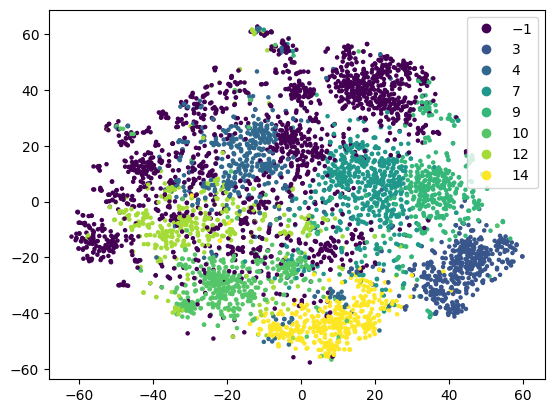

In [81]:
from matplotlib import pyplot as plt

scatter = plt.scatter(tsne[:, 0], tsne[:, 1], s=5, c=np.where(np.isin(clusters, top_clust), clusters, -1))
legend1 = plt.legend(*scatter.legend_elements())

Let's check some examples

In [62]:
def print_topic_samples(cluster_id):
    cluster0 = larger_sample[clusters == cluster_id]
    for i in cluster0.sample(5).text.tolist():
      print(i)

In [97]:
print("Cluster:", 7)
print_topic_samples(7)

Cluster: 7
@115858 @AppleSupport why has no one else got iOS 11.1 yet ? I’m stuck here with it .....
I did this bullshit apple update and now my phone isn’t working right. @115858
I love iPhones but @115858 is fucking bullshit. If I wasn’t $700 in on this piece of freezing garbage I call my new phone, I would probably switch to something else.
Thanks @115858 my @797 is completely useless piece of 💩 since you updated iOS 11
Ne kadar berbat iğrenç bir sürümdür bu iOS 11.2 Allah sizi kahretsin lanetler @115858 @AppleSupport


In [90]:
print("Cluster:", 3)
print_topic_samples(3)

Cluster: 3
Hey @115858 fix this €~%£
I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️ I️
.@115858 when are you going to fix the issue with the letter “I️” in your emails?? Can’t work from phone!
@115858 give me an explanation why errytime I️ type “I️” you change it to some freaky shit
while stressing over snapchat, @115858 when will “i️” be able to type the letter i** without it coming up as symbols and numbers !!!
@115858 you guys need to fix texts. I’m tired of typing “i” and getting this I️


Having the vectors, we can search for similar questions. So, if our support has previously answered some questions, we may want to reuse this knowledge incorporating some messages inside the prompt.

In [157]:
simple_prompt = """You are a support bot. Your goal is to help users solve problems. You will be provided with user question and set of answers on similar questions. You should generate answer based on it.

Question: ```{query}```
Answer:
"""

print(llm(
  simple_prompt.format(
      query="Hi @AppleSupport, my phone freezes after update and i cant restart it")
  ))

We're sorry to hear that you're experiencing issues with your phone freezing after updating it. Have you tried a hard reset? To do this, press and hold both the Home and Power buttons simultaneously for at least 10 seconds until the Apple logo appears. If that doesn't work, you may need to connect your phone to a computer and restore it using iTunes. Let us know if you need further assistance.


In [153]:
def find_similar_texts(query, k=5):
    emb = embeddings.embed_query(query)
    indices = vecs.dot(np.array(emb)).argsort()[-k:]
    tweet_ids = (larger_sample.iloc[indices].response_tweet_id.str.split(",").str[-1])
    tweet_ids = tweet_ids[tweet_ids.notnull()].astype(int)
    tweets = data[data.tweet_id.isin(tweet_ids)]
    return tweets.text.tolist()

In [154]:
prompt = """You are a support bot. Your goal is to help users solve problems. You will be provided with user question and set of answers on similar questions. You should generate answer based on it.

Question: ```{query}```
Answer on similar questions:
```
{answers}
```

Answer:
"""

In [155]:
print(    prompt.format(
        query="Hi @AppleSupport, my phone freezes after update and i cant restart it",
        answers='\n'.join(find_similar_texts("Hi @AppleSupport, my phone freezes after update and i cant restart it"))
    ))

You are a support bot. Your goal is to help users solve problems. You will be provided with user question and set of answers on similar questions. You should generate answer based on it.

Question: ```Hi @AppleSupport, my phone freezes after update and i cant restart it```
Answer on similar questions:
```
@192784 We'd like to work with you. May we ask which iOS you're currently on?
@351406 We'd be happy to help you out! Send us a DM to get started. https://t.co/GDrqU22YpT
@403735 We'd love to work together on this with you. Meet us in DM with additional details to get started: https://t.co/GDrqU22YpT
@608152 We're more than happy to work on a resolution with you. Please DM your iPhone model, iOS, and country. We'll meet you there! https://t.co/GDrqU2kzhr
@746856 We certainly want you to get the best performance from your iPhone. To help get us started through troubleshooting, select the following to join us in a DM and let us know the iOS version shown in Settings &gt; General &gt; Abo

In [156]:
(llm(
    prompt.format(
        query="Hi @AppleSupport, my phone freezes after update and i cant restart it",
        answers='\n'.join(find_similar_texts("Hi @AppleSupport, my phone freezes after update and i cant restart it"))
    )
))

"Hello! We're sorry to hear that you're experiencing issues with your phone after updating. We'd be happy to assist you with this. Before we proceed, may we ask which iOS version you're currently on? This will help us determine the next steps to resolve the issue. Thank you!"

This answer looks much closer to the style of Apple Support